# Rabi Measurements

***Collin Bradford***

This example code runs rabi measurements to find $t_\pi$, $t_\pi/2$, and $t_1$. To accomplish this, an excitation pulse is sent to the qubit. An optional delay is allowed for the qubit to relax, followed by a readout pulse. A final optional delay is allowed before the next measurement. A diagram of a typical pulse cycle is given below. 

<img align="center" width="750" height="375" src="images/rabi-pulse-diagram.PNG">

The code is designed to sweep through the following variable parameters on the FPGA to provide a fast characterization of the qubit. 

* Gain for the excitation pulse
* Time duration of the qubit excitation pulse
* Time duration of the pre-readout relaxation time

Other variables that can be changed but remain constant across the run: 

* Frequency of the qubit pulse
* Frequency of the cavity pulse
* Gain of the cavity pulse
* Duration of the post-readout relaxation time
* Outer loop iteration count
* Inner loop iteration count

To sweep a variable, both a start and delta values are given. For every iteration of the loop within which the variable is changed, the delta value is added to the variable. Thus, the start value defines the start, the delta value defines the step and the loop variable defines the number of steps taken. 

There are three loops within the ASM firmware. The most outer loop increments the gain, the middle loop increments both the pre-readout delay time and the qubit pulse time. The most inner loop does not increment anything. Rather, the inner loop is designed to run the given test several times without changing variables. In python code, this process functions just like the following: 

```
gainStart = x
gainDelta = x
gainLoopCount = x

pulseStart = x
pulseDelta = x
delayStart = x
delayDelta = x
pulseLoopCount = x

iterationLoopCount = x

gain = gainStart

for g in range(gainLoopCount):
    pulseDuration = pulseStart
    delayDuration = delayStart
    for p in range(pulseLoopCount):
        for i in range(iterationLoopCount):
            pulse(gain, duration)
            delay(delay)
            readout...
        pulseDuration = pulseDuration + pulseDelta
        delayDuration = delayDuration + delayDelta
    gain = gain + gainDelta
```

#### Example

If one were to have the following settings: 

```
qubitStartGain = 5000
qubitDeltaGain = 5000

qubitStartTimeNS = 0 #nanoseconds
qubitDeltaTimeNS = 1 #nanoseconds

preReadoutDelayStartNS = 0 #nanoseconds
preReadoutDelayDeltaNS = 0 #nanoseconds, 0.05 us

gainLoopCount = 6
pulseDurationLoopCount = 200
iterationLoopCount = 10
```

The program would run 12,000 experiments. It would sweep the gain from 5,000 to 30,000 and for each step of 5,000, it would sweep the qubit excitation pulse from 0 to 200 nanoseconds in steps of 1 nanosecond each. For each step of the qubit excitation pulse, the experiment would be repeated 10 times. 

#### Timing 

It is important to note that due to the clock frequency of the FPGA, the real delay values may not reflect the numbers provided. In the current configuration, the clock frequency is 384 MHz which yields a percision of 2.6 nanoseconds. Thus, for the previous example, even though we stepped the delay by 1 nanosecond, the real step vale would be 2.6 nanoseconds and some tests would be run multiple times. It is important to keep these things in mind when designing a test. 

#### Plot

The following values were used to create a plot that demonstrates the timing and capabilities of the program: 

```
qubitFrequency = 15 #MHz
cavityFrequency = 15 #MHz
cavityGain = 32767

qubitStartGain = 10000
qubitDeltaGain = 10000

qubitStartTimeNS = 100 #nanoseconds, 0.1 us
qubitDeltaTimeNS = 25 #nanoseconds, 0.025 us

preReadoutDelayStartNS = 0 #nanoseconds
preReadoutDelayDeltaNS = 50 #nanoseconds, 0.05 us

readoutPulseDurationNS = 100 #nanoseconds, 0.1 us
postReadoutRelaxationTimeNS = 200 #nanoseconds 0.2 us

gainLoopCount = 3
pulseDurationLoopCount = 3
iterationLoopCount = 3
```

In the graph, the yellow trace is the qubit pulse, the green trace is the readout pulse, and the blue trace is the trigger for the readout block. 

<img align="center" src="images/rabi-pulse-graph.PNG">

### Address Space

* 1: Frequency for the qubit channel 
* 2: Start gain for the qubit channel
* 3: Delta gain for the qubit channel
* 4: Start time duration for the qubit excitation pulse
* 5: Delta time for the qubit excitation pulse
* 6: Frequency for the cavity channel
* 7: Gain for the cavity channel
* 8: Time duration for the cavity readout pulse
* 9: Gain loop count
* 10: Qubit pulse loop count
* 11: Time duration for the delay given after a readout pulse. 
* 12: Start time duration for the relaxation time given between the excitation pulse and the readout pulse
* 13: Delta time for the relaxation time given between the excitation pulse and the readout pulse. 
* 14: Iteration count

### Register Space

* Page 0:
    * 1: Frequency for the qubit channel
    * 2: Start/current gain for the qubit channel
    * 3: Delta gain for the qubit channel
    * 4: Start time duration for the qubit excitation pulse
    * 5: Delta time for the qubit excitation pulse
    * 6: Frequency for the cavity channel
    * 7: Gain for the cavity channel
    * 8: Time duration for the cavity readout pulse
    * 9: Output settings for the qubit pulse channel
    * 10: Combined output settings + pulse duration value for the qubit channel
    * 11: Output settings + pulse duration for cavity channel (Since this does not change, we only use one register)
    * 12: Relaxation time duration for the delay given after a readout pulse. 
    * 13: Start time duration for the delay given beteween the excitation pulse and a readout pulse
    * 14: Delta time for the delay given between the excitation pulse and a readout pulse
    * 15: Current time duration for qubit excitation pulse
    * 16: Current time duration for the delay given between the excitation pulse and the readout pulse
* Page 2:
    * 1: Gain loop count
    * 2: Qubit pulse loop count
    * 3: Iteration loop count
    * 4: Quibt pulse current loop count
    * 5: Iteration current loop count
    * 6: Output trigger enable. This is written to output 0 to enable the external trigger and the readout block. It is written during the cavity readout pulse. 

In [257]:
#Imports

import matplotlib.pyplot as plt

from pynq import Overlay
import numpy as np

from qsystem_2 import *
from qsystem2_asm import *

In [258]:
#Load the bitfile

soc = PfbSoc('qsystem_2.bit', force_init_clks=False)

In [289]:
#Program Variables for Some Testing

qubitOutputChannel = 7 #1 - 7
cavityOutputChannel = 6 #1 - 7
inputChannel = 0 #0 or 1

qubitFrequency = 15 #MHz
cavityFrequency = 15 #MHz
cavityGain = 32767

qubitStartGain = 10000
qubitDeltaGain = 10000

qubitStartTimeNS = 100 #nanoseconds, 0.1 us
qubitDeltaTimeNS = 25 #nanoseconds, 0.025 us

preReadoutDelayStartNS = 0 #nanoseconds
preReadoutDelayDeltaNS = 50 #nanoseconds, 0.05 us

readoutPulseDurationNS = 100 #nanoseconds, 0.1 us
postReadoutRelaxationTimeNS = 200 #nanoseconds 0.2 us

gainLoopCount = 3
pulseDurationLoopCount = 3
iterationLoopCount = 3

clockPeriodNS = 2.6 #nanoseconds

In [290]:
enableTrigger = True
triggerDelay = 35

#ASM 
with ASM_Program() as p:
    #Write all memory addresses to program memory
    #Set the frequency for the qubit channel 
    p.memri(0, 1, 1,"freq qubit channel")
    #Set the start gain and delta gain for the qubit channel
    p.memri(0, 2, 2,"start/current gain qubit channel")
    p.memri(0, 3, 3,"delta gain qubit channel")
    #Set the start time and delta time for the qubit excitation pulse
    p.memri(0, 4, 4,"start time qubit excitation pulse")
    p.memri(0, 5, 5,"delta time for qubit excitation pulse")
    #Set the frequency, gain, and time for the cavity readout pulse
    p.memri(0, 6, 6,"Freuqency for cavity readount pulse")
    p.memri(0, 7, 7,"Gain for cavity readount pulse")
    p.memri(0, 8, 8,"Time duration for cavity readout pulse")
    #Set the post-readout relaxation time
    p.memri(0, 12, 11,"Post-readout relaxation time")
    #Set the pre-readout relaxation time
    p.memri(0, 13, 12,"Pre-readout start relaxation time")
    p.memri(0, 14, 13,"Pre-readout delta relaxation time")
    #Set the outer and inner loop count registers
    p.memri(1, 1, 9,"Gain loop count")
    p.memri(1, 2, 10,"Qubit pulse time loop count")
    p.memri(1, 3, 14,"Iteration loop count")
    #Trigger value for the average block. This will be enabled during the cavity readout pulse
    p.regwi(1,6, 0x4001 if inputChannel == 0 else 0x8001)
    #Set up the DAC selection and pulse duration register for the qubit channel
    p.regwi(0,9,0b1001,"0b1001, stdysel = 1 (zero value), mode = 0 (nsamp), outsel = 01 (DDS).") #Value
    p.bitwi(0,9,9, "<<", 16) #Shift it left and leave it in r9
    p.bitw(0,10,15,"|",9) #Combine the settings into register 10. We use a different register so that we can combine values in fewer steps later when the pulse duration changes. 
    #Set up the DAC Selection and pulse duration register for the cavity channel. We use the same ouptut select because it is the same for both channels. Only the pusle duration is different for this register. 
    p.bitw(0,11,8,"|",9)
    #Delay the start a bit
    p.synci(1000)
    #Loop
    p.label("GAIN_LOOP")
    #Reset the pulse loop count
    p.math(1,4,0,"+",2) #Reset the pulse loop
    #Reset all things iterated in the pulse_loop loop
    p.math(0,15,0,"+",4) #Reset the pulse duration
    p.math(0,16,0,"+",13) #Reset the pre-readout delay
    p.bitw(0,10,15,"|",9) #Update the pulse duration. 
    p.label("PULSE_LOOP")
    #Reset the iteration loop count
    p.math(1,5,0,"+",3)
    p.label("ITERATION_LOOP")
    #Que the qubit pulse immediately and que all later operations after it finishes
    p.set(qubitOutputChannel,0,1,0,0,2,10,0)
    p.sync(0,15)
    #Delay for the pre-readout delay
    p.sync(0,16)
    #Que the readout pulse right after the qubit pulse, start the trigger, and que all later operations after it finishes
    p.set(cavityOutputChannel,0,6,0,0,7,11,0)
    if enableTrigger: 
        p.seti(0,1,6,triggerDelay)
    p.sync(0,8)
    #Delay for the relaxation time
    #Disable the trigger
    if enableTrigger: 
        p.seti(0,1,0,triggerDelay)
    p.sync(0,12)
    p.loopnz(1,5,"ITERATION_LOOP")
    #Run the math to add the gain values and time delay values for the next iteration of the inner loop. 
    p.math(0,15,15,"+",5) #Add delta time to the current time and store it in the current time register. 
    p.math(0,16,16,"+",14) #Add the delta pre-readout time delay to the pre-readout time delay. 
    p.bitw(0,10,15,"|",9) #Update the pulse duration. 
    p.loopnz(1,4,"PULSE_LOOP")
    p.math(0,2,2,"+",3) #Add delta gain to the current gain and store it in the current gain register. 
    p.loopnz(1,1,"GAIN_LOOP")
    #End the signal
    p.seti(0,0,0,0)
soc.tproc.load_asm_program(p)

In [291]:
#Python code

def timeToClocks(nanoseconds):
    return int(np.rint(nanoseconds / clockPeriodNS))

def rabiMeasurement(qFreq=qubitFrequency,
                    cavFreq=cavityFrequency,
                    qsGain=qubitStartGain,
                    qdGain=qubitDeltaGain,
                    qsTimeNS=qubitStartTimeNS,
                    qdTimeNS=qubitDeltaTimeNS,
                    cavGain=cavityGain,
                    preReadoutDelayStartNS=preReadoutDelayStartNS,
                    preReadoutDelayDeltaNS=preReadoutDelayDeltaNS,
                    readoutPulseDurationNS=readoutPulseDurationNS,
                    postReadoutRelaxationTimeNS=postReadoutRelaxationTimeNS,
                    gainLoopCount=gainLoopCount,
                    pulseDurationLoopCount=pulseDurationLoopCount,
                    iterationLoopCount=iterationLoopCount):
    
    #Populate the address space. 
    qFreqReg = freq2reg(soc.fs_dac, qFreq, B=32)
    soc.tproc.single_write(addr=1, data=qFreqReg)
    
    soc.tproc.single_write(addr=2, data=qsGain)
    soc.tproc.single_write(addr=3, data=qdGain)
    
    qsTimeClocks = timeToClocks(qsTimeNS)
    soc.tproc.single_write(addr=4, data=qsTimeClocks)
    qdTimeClocks = timeToClocks(qdTimeNS)
    soc.tproc.single_write(addr=5, data=qdTimeClocks)
    
    cavFreqReg = freq2reg(soc.fs_dac, cavFreq, B=32)
    soc.tproc.single_write(addr=6, data=cavFreqReg)
    soc.tproc.single_write(addr=7, data=cavGain)
    readoutPulseDurationClocks = timeToClocks(readoutPulseDurationNS)
    soc.tproc.single_write(addr=8, data=readoutPulseDurationClocks)
    
    soc.tproc.single_write(addr=9, data=gainLoopCount-1)
    soc.tproc.single_write(addr=10, data=pulseDurationLoopCount-1)
    soc.tproc.single_write(addr=14, data=iterationLoopCount-1)
    
    postReadoutRelaxationTimeClocks = timeToClocks(postReadoutRelaxationTimeNS)
    soc.tproc.single_write(addr=11, data=postReadoutRelaxationTimeClocks)
    
    preReadoutDelayStartClocks = timeToClocks(preReadoutDelayStartNS)
    soc.tproc.single_write(addr=12, data=preReadoutDelayStartClocks)
    preReadoutDelayDeltaClocks = timeToClocks(preReadoutDelayDeltaNS)
    soc.tproc.single_write(addr=13, data=preReadoutDelayDeltaClocks)
    
    
    decimatedLength = readoutPulseDurationClocks
    accumulatedLength = gainLoopCount * pulseDurationLoopCount * iterationLoopCount
    
    #Set up the readout buffer
    soc.readouts[inputChannel].set_out("product")
    soc.readouts[inputChannel].set_freq(cavFreq)
    soc.avg_bufs[inputChannel].config(address=inputChannel, length=decimatedLength)
    soc.avg_bufs[inputChannel].enable()
    
    #Start tProc
    #soc.setSelection("product")
    soc.tproc.stop()
    soc.tproc.start()
    
    time.sleep(1)
    
    idec,qdec = soc.get_decimated(ch=inputChannel)
    iacc,qacc = soc.get_accumulated(ch=inputChannel, length=accumulatedLength)
    
    return idec, qdec, iacc, qacc

In [292]:
try: 
    idec,qdec,iacc,qacc = rabiMeasurement()
except:
    print("Exception")

Exception


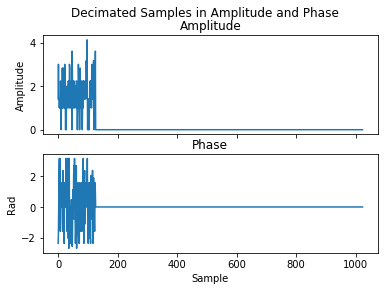

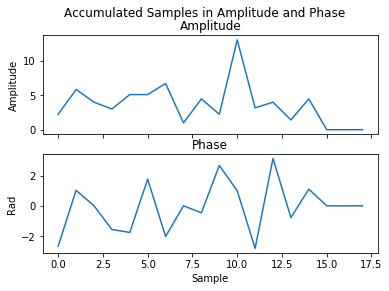

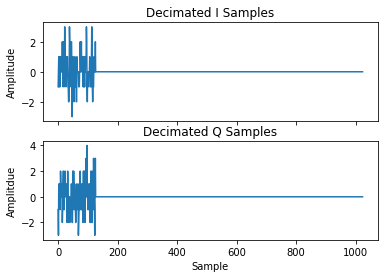

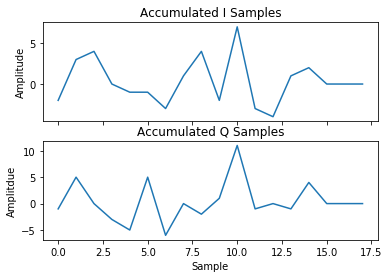

In [76]:
#Receive Information from the rabi measurement defined at the top of the file. 

idec,qdec,iacc,qacc = rabiMeasurement()

decMagnitudes = np.abs(idec + 1j * qdec)
decPhases = np.angle(idec + 1j * qdec)

accMagnitudes = np.abs(iacc + 1j * qacc)
accPhases = np.angle(iacc + 1j * qacc)

fig,ax = plt.subplots(2,1,sharex=True)
plt.suptitle("Decimated Samples in Amplitude and Phase")
ax[0].plot(decMagnitudes)
ax[0].set_title("Amplitude")
ax[0].set_ylabel("Amplitude")
ax[1].plot(decPhases)
ax[1].set_title("Phase")
ax[1].set_ylabel("Rad")
ax[1].set_xlabel("Sample")
'''
for i in range(0, iterations):
    ax[0].axvline(nsamp * (i+1), color="r", alpha=0.25)
    ax[1].axvline(nsamp * (i+1), color="r", alpha=0.25)
'''
plt.show()

fig,ax = plt.subplots(2,1,sharex=True)
plt.suptitle("Accumulated Samples in Amplitude and Phase")
ax[0].plot(accMagnitudes)
ax[0].set_title("Amplitude")
ax[0].set_ylabel("Amplitude")
ax[1].plot(accPhases)
ax[1].set_title("Phase")
ax[1].set_ylabel("Rad")
ax[1].set_xlabel("Sample")
'''
for i in range(0, iterations):
    ax[0].axvline(nsamp * (i+1), color="r", alpha=0.25)
    ax[1].axvline(nsamp * (i+1), color="r", alpha=0.25)
'''
plt.show()

fig,ax = plt.subplots(2,1,sharex=True)
ax[0].plot(idec)
ax[0].set_title("Decimated I Samples")
ax[0].set_ylabel("Amplitude")
ax[1].plot(qdec)
ax[1].set_title("Decimated Q Samples")
ax[1].set_ylabel("Amplitdue")
ax[1].set_xlabel("Sample")
'''
for i in range(0, iterations):
    ax[0].axvline(nsamp * (i+1), color="r", alpha=0.25)
    ax[1].axvline(nsamp * (i+1), color="r", alpha=0.25)
'''
plt.show()

fig,ax = plt.subplots(2,1,sharex=True)
ax[0].plot(iacc)
ax[0].set_title("Accumulated I Samples")
ax[0].set_ylabel("Amplitude")
ax[1].plot(qacc)
ax[1].set_title("Accumulated Q Samples")
ax[1].set_ylabel("Amplitdue")
ax[1].set_xlabel("Sample")
'''
for i in range(0, iterations):
    ax[0].axvline(nsamp * (i+1), color="r", alpha=0.25)
    ax[1].axvline(nsamp * (i+1), color="r", alpha=0.25)
'''
plt.show()